In [1]:
from itertools import product
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

In [2]:
def feature_normalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma


def cost(X, y, theta, regularize=None, lambda_=None):
    m = X.shape[0]
    pred = predict(X, theta)
    J = ((pred - y) ** 2).sum()
    if regularize is None:
        pass
    elif regularize == 'ridge':
        J += lambda_ * (theta[1:] ** 2).sum()
    elif regularize == 'lasso':
        J += lambda_ * np.abs(theta[1:]).sum()
    elif regularize == 'elastic_net':
        J += lambda_ * ((theta[1:] ** 2).sum() + np.abs(theta[1:]).sum())
    else:
        raise ValueError('regularize must be one of "ridge", "lasso", or "elastic_net"')
    J /= 2 * m
    return J


def gradient_descent(X, y, theta, alpha, n_iter, regularize=None, lambda_=None):
    J_history = []
    theta_history = []
    for _ in range(n_iter):
        pred = predict(X, theta)
        gradient = 1 / m * X.T @ (pred - y)
        if regularize is None:
            pass
        elif regularize == 'ridge':
            gradient += lambda_ / m * np.hstack([np.zeros(1), theta[1:]])
        elif regularize == 'lasso':
            d = np.abs(theta[1:]) / theta[1:]
            gradient += lambda_ / (2*m) * np.hstack([np.zeros(1), d])
        elif regularize == 'elastic_net':
            d = np.abs(theta[1:]) / theta[1:]
            gradient += lambda_ / m * (np.hstack([np.zeros(1), theta[1:]])
                                       + np.hstack([np.zeros(1), d]) / 2)
        else:
            raise ValueError('regularize must be one of "ridge", "lasso", or "elastic_net"')
        theta = theta - alpha * gradient
        theta_history.append(theta)
        J = cost(X, y, theta, regularize=regularize, lambda_=lambda_)
        J_history.append(J)
    theta_history = np.array(theta_history)
    return theta, theta_history, J_history


def predict(X, theta):
    pred = X @ theta
    return pred


def plot_gradient(J_history, step, title):
    # Line plot
    plt.plot(range(1, n_iter+1)[::step], J_history[::step])
    plt.scatter(range(1, n_iter+1)[::step], J_history[::step], s=7)
    plt.xlabel('Number of Iterations')
    plt.ylabel('J($\Theta$)')
    plt.title(title)


def plot_contour(theta_history, step, title):
    # Contour plot
    theta0_vals = np.linspace(0, 40, 100)
    theta1_vals = np.linspace(-15, 5, 100)
    X_, Y_ = np.meshgrid(theta0_vals, theta1_vals)
    theta0_len = len(theta0_vals)
    theta1_len = len(theta1_vals)
    J_vals = np.zeros((theta1_len, theta0_len))
    for i in range(theta1_len):
        for j in range(theta0_len):
            t = np.array([theta0_vals[j], theta1_vals[i]])
            J_vals[i, j] = cost(X, y, t)
    plt.contour(X_, Y_, J_vals, 15, zorder=0)

    # Trajectory of theta
    theta0_history = theta_history[::step, 0]
    theta1_history = theta_history[::step, 1]
    for i in range(len(theta0_history)-1):
        xy = (theta0_history[i+1], theta1_history[i+1])
        xytext = (theta0_history[i], theta1_history[i])
        plt.annotate('', xy=xy, xytext=xytext,
                     arrowprops=dict(color='dimgray', width=0.5, headwidth=3), zorder=1)
    plt.scatter(theta0_history, theta1_history, color='k', zorder=2, s=7)
    plt.scatter(theta0_history[-1], theta1_history[-1], color='r', zorder=3)
    plt.xlabel('$\Theta_0$')
    plt.ylabel('$\Theta_1$')
    plt.title(title)


def plot_gc(theta_history, J_history, nrows, row, step=40, title=None):
    plt.subplot(nrows, 2, 2*row-1)
    plot_gradient(J_history, step=step, title=title)
    plt.subplot(nrows, 2, 2*row)
    plot_contour(theta_history, step=step, title=title)    

In [3]:
# Load data
boston = load_boston()
X = boston.data[:, 12]
y = boston.target

# Scale features
X, mu, sigma = feature_normalize(X)

# Add intercept term to X
m = X.shape[0]
intercept = np.ones((m, 1))
if X.ndim == 1:
    X = np.hstack([intercept, X.reshape(-1, 1)])
else:
    X = np.hstack([intercept, X])

# Initialize theta
n = X.shape[1]
theta = np.array([1e-10] * n)

alpha = 0.01
n_iter = 400
models = ['ridge', 'lasso', 'elastic_net']
lambdas = [0.1, 7e4]

# Run gradient descent
histories = [gradient_descent(X, y, theta, alpha, n_iter, m, l) for m in models for l in lambdas]

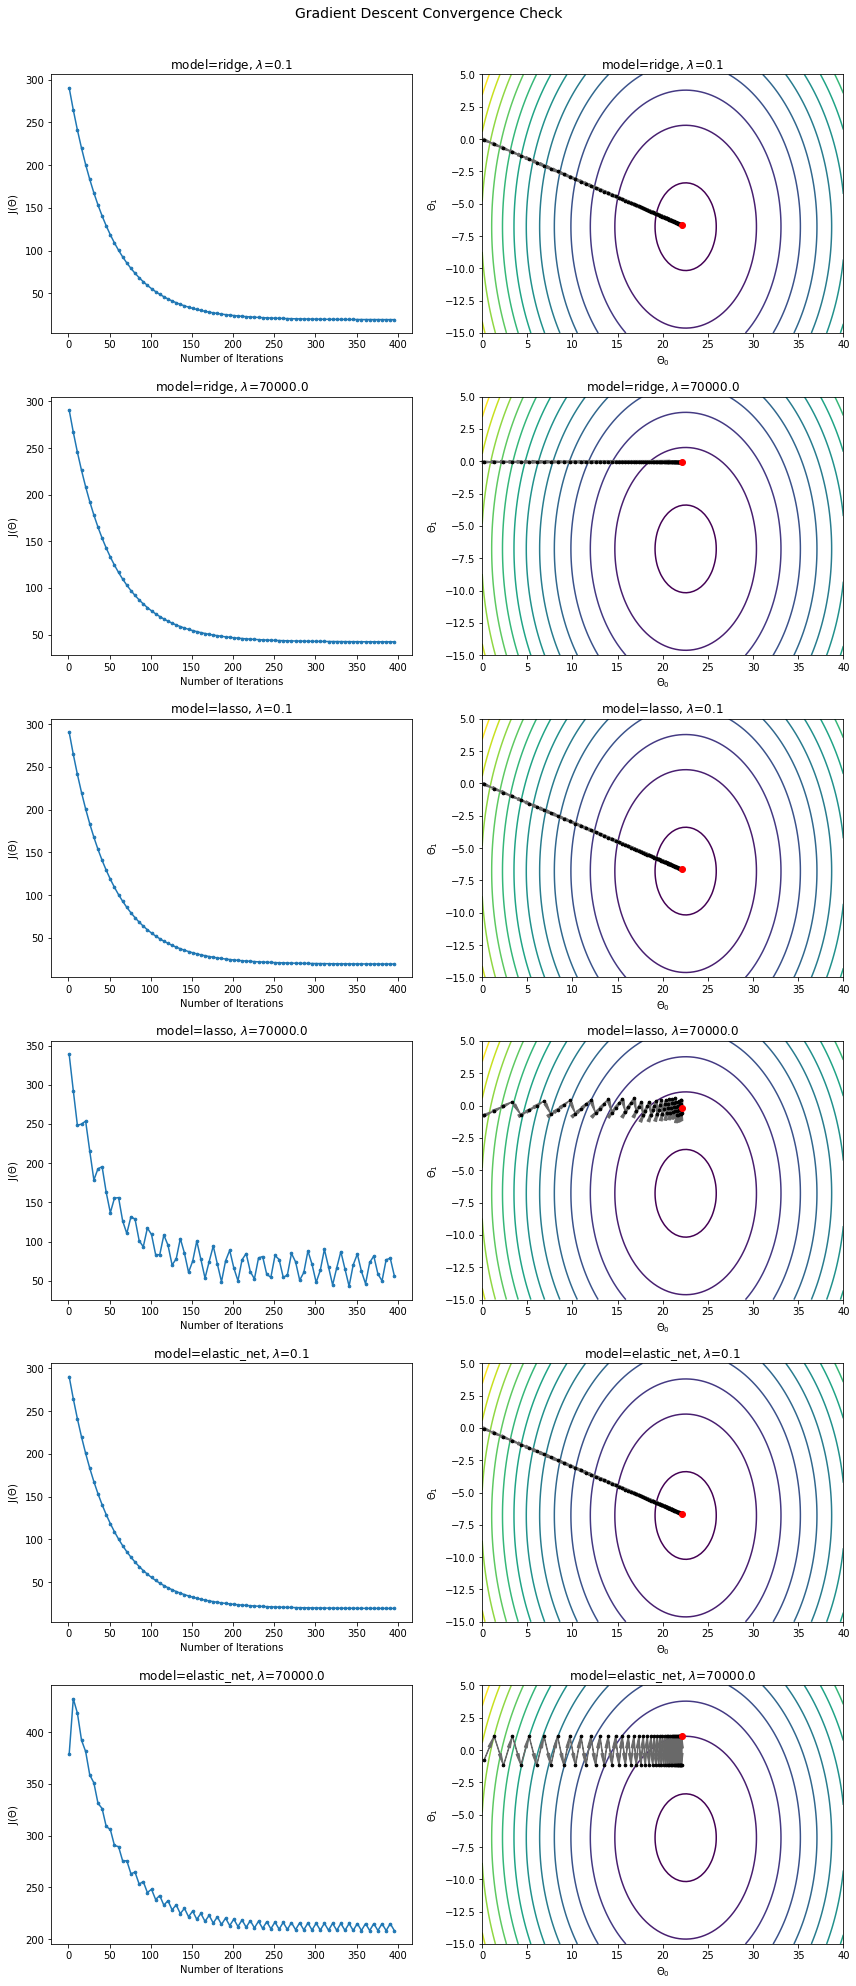

In [4]:
ml_products = product(models, lambdas)
nrows = len(models) * len(lambdas)

plt.subplots(figsize=(12, 4.5*nrows))
step = 5

for i, ((model, lambda_), (theta, theta_history, J_history)) in enumerate(zip(ml_products, histories)):
    plot_gc(theta_history, J_history, nrows, i+1, step,
            'model={}, $\lambda$={}'.format(model, lambda_))

plt.tight_layout()
plt.suptitle('Gradient Descent Convergence Check', y=1.02, fontsize=14)
plt.show()

In [5]:
# Load data
boston = load_boston()
X = boston.data[:, 12]
# Add polynomial features
powers = map(lambda p: X.reshape(-1, 1) ** p, range(1, 5))
X = reduce(lambda x, y: np.hstack([x, y]), powers)
y = boston.target

# Scale features
X, mu, sigma = feature_normalize(X)

# Add intercept term to X
m = X.shape[0]
intercept = np.ones((m, 1))
if X.ndim == 1:
    X = np.hstack([intercept, X.reshape(-1, 1)])
else:
    X = np.hstack([intercept, X])

# Initialize theta
n = X.shape[1]
theta = np.array([1e-10] * n)

alpha = 0.01
n_iter = 400
models = ['ridge', 'lasso', 'elastic_net']
lambdas = [100, 1e4]

# Run gradient descent
histories = [gradient_descent(X, y, theta, alpha, n_iter, m, l) for m in models for l in lambdas]

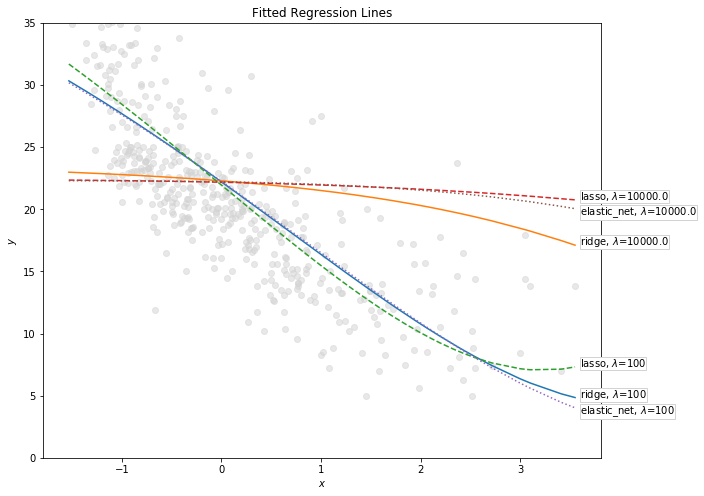

In [6]:
ml_products = product(models, lambdas)
x = X[:, 1]
xmax = x.max()
linestyles = dict(ridge='-', lasso='--', elastic_net=':')
text_ys = []
bbox_props = dict(boxstyle='square, pad=0', fc='white', ec='lightgray')

fig, ax = plt.subplots(figsize=(10, 8))
plt.scatter(x, y, alpha=0.5, c='lightgray')
for (model, lambda_), (theta, theta_history, J_history) in zip(ml_products, histories):
    pred = predict(X, theta)
    pred_sorted = [p for _, p in sorted(zip(x, pred))]
    plt.plot(sorted(x), pred_sorted, linestyle=linestyles[model])
    text_y = pred_sorted[-1]
    dists = [abs(text_y - other) for other in text_ys]
    if dists:
        min_dist = min(dists)
        if min_dist < 1:
            nearest_y = text_ys[dists.index(min_dist)]
            if text_y > nearest_y:
                text_y += 0.5
            else:
                text_y -= 0.5
    ax.text(xmax+0.05, text_y, '{}, $\lambda$={}'.format(model, lambda_), bbox=bbox_props)
    text_ys.append(text_y)
plt.ylim((0, 35))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fitted Regression Lines')
plt.show()